# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — Part B

## Setup

In [3]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
import librosa
import dsp.filterFuncs
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg

In [4]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]


# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# select figure output save path
app = QApplication(sys.argv)
outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

## Import data and organise

In [5]:
# import data
app = QApplication(sys.argv)
fileExts = "*.csv"

# Part B by stimulus
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

# Part B
partBDataFilePath = list(QFileDialog.getOpenFileName(filter=fileExts,
                                                     caption=r"Open refmap_listest1_testdataB_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partBDataBySubj = pd.read_csv(partBDataFilePath, index_col=False)


In [6]:
# categorise columns

for dataset in [dataByStimTestB, partBDataBySubj]:
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"])
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"])
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby"])
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"])

## Exploratory data analysis
In this section, exploratory plots are used to examine the PartBA data for information and possible trends.

Responses are analysed using violin and scatter plots, segregating the data by the categorical variables UAS LAeUAS Events (quantity or density), e, UAS/Ambi signal-noise-ratio, and UAS type.pe.

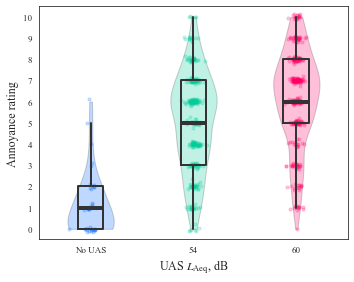

In [19]:
UASLAeqCats = list(partBDataBySubj['UASLAeq'].sort_values().unique())

fig, ax = plt.subplots(figsize=(5, 4))

y_data = [partBDataBySubj[partBDataBySubj['UASLAeq']
                          == LAeq]['Annoyance'].values
          for LAeq in UASLAeqCats]

xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]

violins = ax.violinplot(y_data,
                        positions=range(0, len(UASLAeqCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(UASLAeqCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(UASLAeqCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASLAeqCats)),
       xticklabels=UASLAeqCats,
       xlabel=r"UAS $L_\mathrm{Aeq}$, dB",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
plt.savefig(os.path.join(outFigPath, "PtBAnnoyByLAeq.svg"),
            format='svg')
plt.show()

The LAeq plot indicates that there is an increase in annoyance with sound level, irrespective of event quantity.)

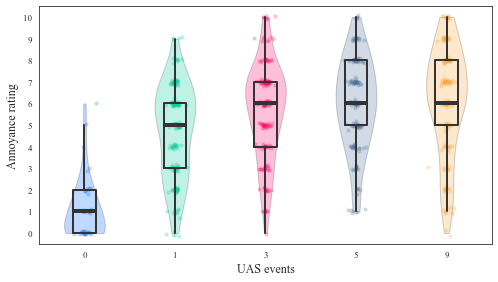

In [9]:
UASEventCats = list(partBDataBySubj['UASEvents'].sort_values().unique().astype(int))

# Annoyance

fig, ax = plt.subplots(figsize=(7, 4))

y_data = [partBDataBySubj[partBDataBySubj['UASEvents']
                          == UASEvents]['Annoyance'].values
          for UASEvents in UASEventCats]

xjitter = 0.03
yjitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=xjitter).rvs(len(x)) for x in x_data]
y_jittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y)) for y in y_data]

violins = ax.violinplot(y_data,
                        positions=range(0, len(UASEventCats)),
                        widths=0.45,
                        bw_method='scott',
                        showmeans=False,
                        showmedians=False,
                        showextrema=False)
for ii, pc in enumerate(violins["bodies"]):
    pc.set_facecolor(mycolours[ii])
    pc.set_edgecolor([0.25, 0.25, 0.25])
    pc.set_linewidth(1)
    pc.set_alpha(0.25)

medianprops = dict(linewidth=4,
                   color=[0.2, 0.2, 0.2],
                   solid_capstyle="butt")

boxprops = dict(linewidth=2,
                color=[0.2, 0.2, 0.2])

ax.boxplot(y_data,
           positions=range(0, len(UASEventCats)),
           showfliers=False,
           showcaps=False,
           medianprops=medianprops,
           whiskerprops=boxprops,
           boxprops=boxprops,
           widths=0.25)

# Add jittered dots
for x, y, color in zip(x_jittered, y_jittered, mycolours[0:len(UASEventCats)]):
    ax.scatter(x, y, s=10, color=color, alpha=0.2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASEventCats)),
       xticklabels=UASEventCats,
       xlabel=r"UAS events",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
plt.savefig(os.path.join(outFigPath, "PtBAnnoyByEvents.svg"),
            format='svg')
plt.show()

The plot by events suggests that annoyance increases with event quantity, but approaches a saturation point at which increasing event quantity does not increase annoyance further.

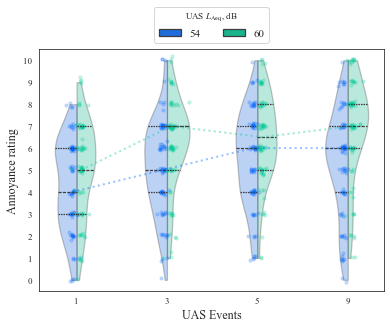

In [15]:
# segregated by LAeq

fig, ax = plt.subplots(figsize=(5.5, 4.65))

data = partBDataBySubj.loc[partBDataBySubj['UASEvents'] > 0,
                           ['UASEvents', 'UASLAeq', 'Annoyance']]
data = data.sort_values('UASEvents')
data['UASLAeq'] = pd.Categorical(data['UASLAeq'], ["54", "60"])

UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
UASLAeqCats = list(data['UASLAeq'].sort_values().unique())

sns.violinplot(data=data, y='Annoyance', split=True, hue='UASLAeq',
               x='UASEvents', cut=0, palette=mycolours[0:len(UASLAeqCats)], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(UASEventCats)):
    y_subdataA.append(data.loc[np.logical_and(data['UASLAeq'] == "54",
                                              data['UASEvents'] == UASEventCats[ii]),
                       'Annoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(data['UASLAeq'] == "60",
                                              data['UASEvents'] == UASEventCats[ii]),
                       'Annoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
                   for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

ax.plot(np.median(x_subdataA, axis=1) - 0.05,
        np.median(y_subdataA, axis=1), ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot(np.median(x_subdataB, axis=1) + 0.05,
        np.median(y_subdataB, axis=1), ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASEventCats)),
       xticklabels=UASEventCats, xlabel=r"UAS Events",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
          title=r"UAS $L_\mathrm{Aeq}$, dB")
plt.savefig(os.path.join(outFigPath, "PtBAnnoyByEventsByLAeq.svg"),
            format='svg')
plt.show()

Segregated by LAeq, the events plot seems to show that the 'saturation point' may occur at different event quantities for each LAeq level; the higher level reaching saturation more quickly.

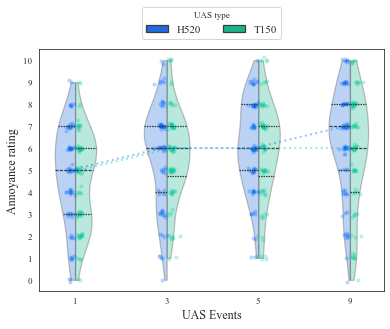

In [14]:
# segregated by UAS type

fig, ax = plt.subplots(figsize=(5.5, 4.65))

data = partBDataBySubj.loc[partBDataBySubj['UASEvents'] > 0,
                           ['UASEvents', 'UASType', 'Annoyance']]
data = data.sort_values('UASEvents')
data['UASType'] = pd.Categorical(data['UASType'], ["H520", "T150"])

UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
UASTypeCats = list(data['UASType'].sort_values().unique())

sns.violinplot(data=data, y='Annoyance', split=True, hue='UASType',
               x='UASEvents', cut=0, palette=mycolours[0:len(UASTypeCats)], inner='quart',
               width=0.5, bw_method='scott')

plt.setp(ax.collections, alpha=0.3)
# Add jittered dots
xjitter = 0.02
yjitter = 0.06
y_subdataA = list()
y_subdataB = list()
for ii in range(0, len(UASEventCats)):
    y_subdataA.append(data.loc[np.logical_and(data['UASType'] == "H520",
                                              data['UASEvents'] == UASEventCats[ii]),
                       'Annoyance'].values)
    y_subdataB.append(data.loc[np.logical_and(data['UASType'] == "T150",
                                              data['UASEvents'] == UASEventCats[ii]),
                       'Annoyance'].values)
x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
x_subdataB = [np.array([i] * len(d))
                   for i, d in enumerate(y_subdataB)]
x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                  for x in x_subdataA]
y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                  for y in y_subdataA]
x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                    for x in x_subdataB]
y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                    for y in y_subdataB]
for x, y in zip(x_Ajittered, y_Ajittered):
    ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
for x, y in zip(x_Bjittered, y_Bjittered):
    ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)

ax.plot(np.median(x_subdataA, axis=1) - 0.05,
        np.median(y_subdataA, axis=1), ':', color=mycolours[0], alpha=0.4,
        linewidth=2)
ax.plot(np.median(x_subdataB, axis=1) + 0.05,
        np.median(y_subdataB, axis=1), ':', color=mycolours[1], alpha=0.4,
        linewidth=2)

ax.set(yticks=range(0, 11), xticks=range(0, len(UASEventCats)),
       xticklabels=UASEventCats, xlabel=r"UAS Events",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
          title="UAS type")
plt.savefig(os.path.join(outFigPath, "PtBAnnoyByEventsByType.svg"),
            format='svg')
plt.show()

Segregated by UAS type, the event plot indicates that there isn't much difference between the two UAS types. 

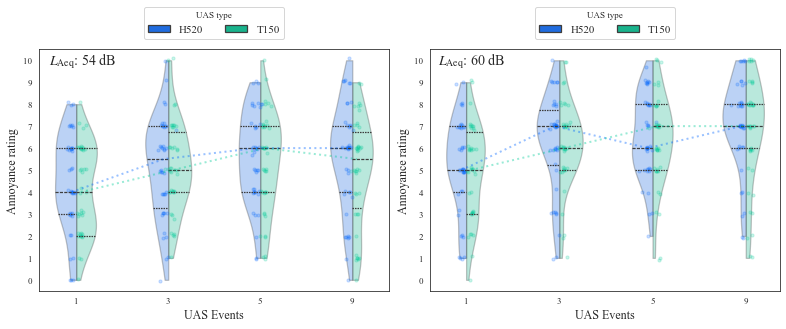

In [16]:
# segregated by UAS LAeq and type

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.65))
UASLAeqs = ["54", "60"]
for iiLAeq, ax in enumerate(axs):
    data = partBDataBySubj.loc[np.logical_and(partBDataBySubj['UASEvents'] > 0,
                                              partBDataBySubj['UASLAeq'] == UASLAeqs[iiLAeq]),
    ['UASEvents', 'UASLAeq', 'UASType', 'Annoyance']]
    
    data = data.sort_values('UASEvents')
    data['UASType'] = pd.Categorical(data['UASType'], ["H520", "T150"])
    
    UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
    UASTypeCats = list(data['UASType'].sort_values().unique())
    
    sns.violinplot(data=data, y='Annoyance', split=True, hue='UASType',
                   x='UASEvents', cut=0, palette=mycolours[0:len(UASTypeCats)],
                   inner='quart', width=0.5, bw_method='scott', ax=ax)
    
    plt.setp(ax.collections, alpha=0.3)
    # Add jittered dots
    xjitter = 0.02
    yjitter = 0.06
    y_subdataA = list()
    y_subdataB = list()
    for jjEvent in range(0, len(UASEventCats)):
        y_subdataA.append(data.loc[np.logical_and(data['UASType'] == "H520",
                                                  data['UASEvents'] == UASEventCats[jjEvent]),
                          'Annoyance'].values)
        y_subdataB.append(data.loc[np.logical_and(data['UASType'] == "T150",
                                                  data['UASEvents'] == UASEventCats[jjEvent]),
                           'Annoyance'].values)
    x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
    x_subdataB = [np.array([i] * len(d))
                       for i, d in enumerate(y_subdataB)]
    x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                      for x in x_subdataA]
    y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                      for y in y_subdataA]
    x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                        for x in x_subdataB]
    y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                        for y in y_subdataB]
    for x, y in zip(x_Ajittered, y_Ajittered):
        ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
    for x, y in zip(x_Bjittered, y_Bjittered):
        ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)
    
    ax.plot(np.median(x_subdataA, axis=1) - 0.05,
            np.median(y_subdataA, axis=1), ':', color=mycolours[0], alpha=0.4,
            linewidth=2)
    ax.plot(np.median(x_subdataB, axis=1) + 0.05,
            np.median(y_subdataB, axis=1), ':', color=mycolours[1], alpha=0.4,
            linewidth=2)
    
    ax.set(yticks=range(0, 11), xticks=range(0, len(UASEventCats)),
           xticklabels=UASEventCats, xlabel=r"UAS Events",
           ylabel="Annoyance rating", ylim=[-0.5, 10.5])
    ax.text(-0.3, 10-0.2, "$L_\mathrm{Aeq}$: " + UASLAeqs[iiLAeq] + " dB", fontsize=14)

    ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
              title="UAS type")
plt.savefig(os.path.join(outFigPath, "PtBAnnoyByEventsByTypeByLAeq.svg"),
            format='svg')
plt.show()